In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/Users/llja0112/repos/Uni-ACS/mimiciv_sepsis_mortality/../medical_explainer.py'>

In [3]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['hosdeath_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(n_estimators=120, max_depth=3, random_state=seed).fit(X_train, y_train)

roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, clf.predict_proba(X_test)[:, 1])
print("Average Precision: " + str(average_precision))

accuracy = accuracy_score(y_test, clf.predict(X_test))
print("Accuracy: " + str(accuracy))

ROC AUC: 0.9019019404532662
Average Precision: 0.44950917888087466
Accuracy: 0.9345470307758994


In [10]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)
# explainer.plot_calibration_original()
# explainer.calibrate()
# explainer.plot_calibration_calibrated()


| Step 1  ==> Calibrating model


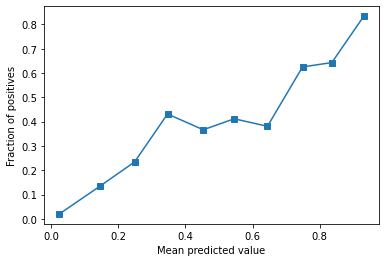

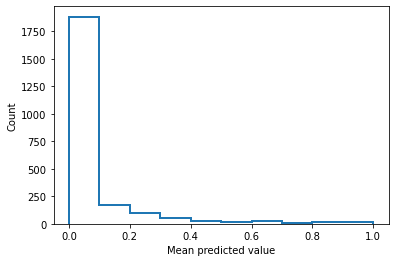

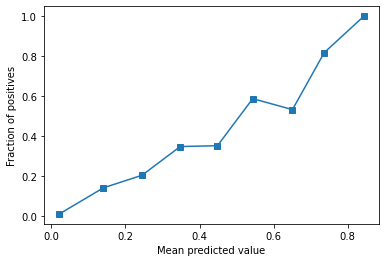

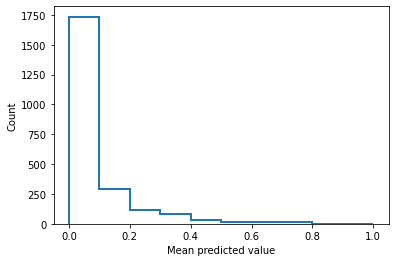

ROC AUC: 0.9019019404532662
Average Precision: 0.44950917888087466
Accuracy: 0.9345470307758994
ROC AUC: 0.9033565397718857
Average Precision: 0.4465456664718051
Accuracy: 0.9375812743823146

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 34.0

Probability threshold: 0.5
Score threshold: 61.0

Probability threshold: 0.9
Score threshold: 63.0



In [11]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='tree', method='novel')

In [12]:
explainer.variables

array(['time2bg_24hr_flag', 'age', 'fbc24hr_rdw_first',
       'chem24hr_bun_first', 'charlson_comorbidity_index',
       'edvital_resprate_median', 'metastatic_solid_tumor',
       'fbc24hr_wbc_first', 'fbc24hr_platelet_first',
       'edvital_sbp_median'], dtype=object)

In [13]:
explainer.score_array_list

[array([-2., 12.]),
 array([-2.,  4.]),
 array([-2.,  3.]),
 array([-2.,  2.]),
 array([-2.,  2., -3.]),
 array([-2.,  3.]),
 array([-1., 12.]),
 array([-0., -1.,  3.]),
 array([ 4., -1.,  1.]),
 array([ 0.,  1., -1.])]

In [14]:
explainer.breakpoints_list

[[0.0, 0.16427234869793622, 1.0],
 [18.0, 77.83893526505003, 98.0],
 [11.1, 14.792250895327225, 29.2],
 [2.0, 22.370083091719703, 243.0],
 [0.0, 5.796008412042867, 18.373662021545414, 20.0],
 [9.5, 19.881159536703848, 62.0],
 [0.0, 0.07759585191839176, 1.0],
 [0.1, 4.160736759588518, 12.216885086584064, 216.3],
 [5.0, 108.14809279285642, 570.7390934306576, 1496.0],
 [10.0, 10.04410942456345, 123.08895631939903, 212.0]]

In [15]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))

ROC AUC: 0.8666864168271368
Average Precision: 0.33670350205210725
Accuracy: 0.9323797139141743
[[2150    0]
 [ 156    1]]


In [17]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [18]:
y_test = y_test.reset_index(drop=True)

In [19]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.8666781874039938, 0.8539115174036527, 0.879444857404335)
(0.3637771557037711, 0.3378722021355361, 0.38968210927200614)
(0.9303, 0.9299591088030862, 0.9306408911969138)
